In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import seed 
from numpy.random import randint 
from math import sqrt,exp,pi
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
def ones_averaging(img,k):
    kernel=np.ones((k,k))
    out_img=np.zeros_like(img)
    row,col=img.shape
    img_pad= np.zeros((row+ k-1,col + k-1))
    upper_zero_cnt= k/2
    u=int(upper_zero_cnt)
    img_pad[u:-u, u:-u] = img
    for i in range(row):
        for j in range(col):
            out_img[i,j]= (kernel*img_pad[i:i+k,j:j+k]).sum()
    return out_img/(k*k)

In [4]:
def filter_1D(img,kernel):
    out_img=np.zeros_like(img)
    row,col=img.shape
    k=kernel.shape[0]
    img_pad= np.zeros((row+ k-1,col + k-1))
    upper_zero_cnt= k/2
    u=int(upper_zero_cnt)
    img_pad[u:-u, u:-u] = img
    for i in range(row):
        for j in range(col):
            out_img[i,j]= (kernel*img_pad[i:i+k,j:j+k]).sum()
    if(kernel.sum()!=0):
        out_img=out_img/(kernel.sum())
    out_img= np.clip(out_img,0,255)
    return out_img.astype(np.uint8)

In [5]:
def bilateral_filt(img1,sig_domain,sig_range,k):
    var_domain=sig_domain**2
    var_range=sig_range**2
    img=np.copy(img1)
    img = img.astype('float32')
    out_img=np.zeros_like(img)
    row,col=img.shape
    img_pad= np.zeros((row+ k-1,col + k-1))
    u= int(k/2)
    img_pad[u:-u, u:-u] = img
    dom = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            dom[i,j] = np.exp(-((i-u)**2 + (j-u)**2)/(2*var_domain))
    for i in range(row):
        for j in range(col):
            range_img = img_pad[i:i+k,j:j+k]
            center_pixel = img_pad[i+u,j+u]
            sub = range_img-center_pixel
            ran = np.exp(-1*((sub**2)/(2*(var_range))))
            kernel=np.multiply(dom,ran)
            out_img[i,j]= np.sum(np.multiply(range_img,kernel))
            out_img[i,j] = out_img[i,j]/np.sum(kernel)
    return out_img
def bilfilt_3D(img, sig1, sig2, k):
    out_img=np.zeros(img.shape)
    if (len(img.shape)==2):
        out_img = bilateral_filt(img, sig1, sig2, k)
    elif (len(img.shape)==3):
        out_img[:,:,0] = bilateral_filt(img[:,:,0],sig1,sig2,k)
        out_img[:,:,1] = bilateral_filt(img[:,:,1],sig1,sig2,k)
        out_img[:,:,2] = bilateral_filt(img[:,:,2],sig1,sig2,k)
    return out_img

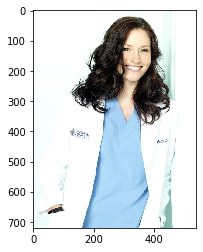

In [6]:
lena=cv.imread('../images/lg.jpg',1)
lena_grey=cv.imread('../images/lg.jpg',0)
lena=cv.cvtColor(lena,cv.COLOR_BGR2RGB)
plt.imshow(lena)

## Step 1

In [7]:
r1 = bilfilt_3D(lena,14,14,15)

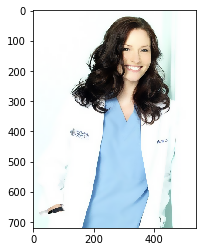

In [8]:
plt.imshow(r1.astype(np.uint8))

## Step 2

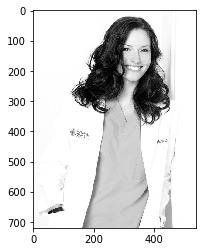

In [9]:
plt.imshow(lena_grey,cmap="gray")

## Step 3

In [231]:
# blur = cv.GaussianBlur(lena_grey,(5,5),0)

In [10]:
gb_5 = np.array([[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]]) ##Gaussian Kernel SIZE==5
gb_3 = np.array([[1,2,1],[2,4,2],[1,2,1]])  #Gaussian Kernel SIZE==3

In [11]:
box5_blur_lena = ones_averaging(lena_grey.astype(np.uint16),5) #Box Filtering with Kernel SIZE == 5
box3_blur_lena = ones_averaging(lena_grey.astype(np.uint16),3) #Box Filtering with Kernel SIZE == 3
ga5_blur_lena = filter_1D(lena_grey.astype(np.uint16),gb_5) #Gaussian Filtering with Kernel SIZE == 5
ga3_blur_lena = filter_1D(lena_grey.astype(np.uint16),gb_3)#Gaussian Filtering with Kernel SIZE == 3

Text(0.5, 1.0, 'Gaussian Filtering size 3')

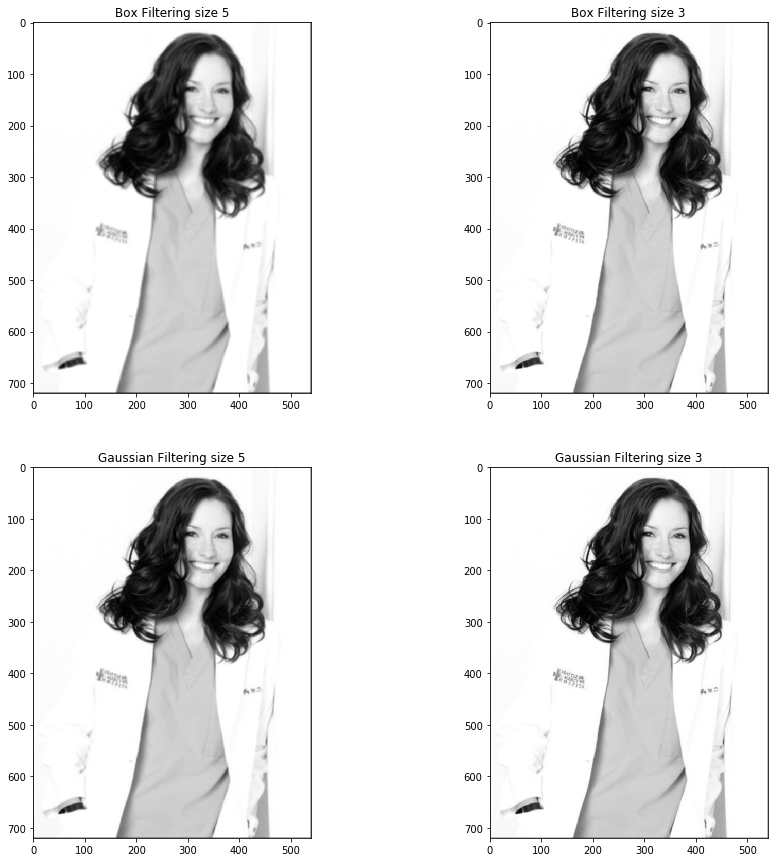

In [12]:
f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0,0].imshow(box5_blur_lena,cmap="gray")
axarr[0,1].imshow(box3_blur_lena,cmap="gray")
axarr[1,0].imshow(ga5_blur_lena,cmap="gray")
axarr[1,1].imshow(ga3_blur_lena,cmap="gray")

axarr[0,0].set_title("Box Filtering size 5")
axarr[0,1].set_title("Box Filtering size 3")
axarr[1,0].set_title("Gaussian Filtering size 5")
axarr[1,1].set_title("Gaussian Filtering size 3")

## Step 4

In [13]:
def adaptiveThresholding(img1,value,block,constant):
    img = np.copy(img1)
    k = block
    mask = np.zeros((k,k),np.float64)
    row,col = img.shape
    u = int(k/2)
    img_new = np.pad(img,((u,u),(u,u)),'constant')
    img_new = img_new.astype(np.uint8)
    for i in range(row):
        for j in range(col):
            mask = img_new[i:i+k,j:j+k]
            thr_val = np.mean(mask) - constant
            if img[i][j] <= thr_val : 
                img[i][j] = 0
            elif img[i][j] > thr_val:
                img[i][j] = value
    return img.astype(np.uint8)

In [14]:
mk1 = adaptiveThresholding(box5_blur_lena,150,11,3)
mk2 = adaptiveThresholding(box3_blur_lena,255,11,3)
mk3 = adaptiveThresholding(ga5_blur_lena,150,11,3)
mk4 = adaptiveThresholding(ga3_blur_lena,150,11,3)

Text(0.5, 1.0, 'Gaussian Filtering size 3 Edge Mask')

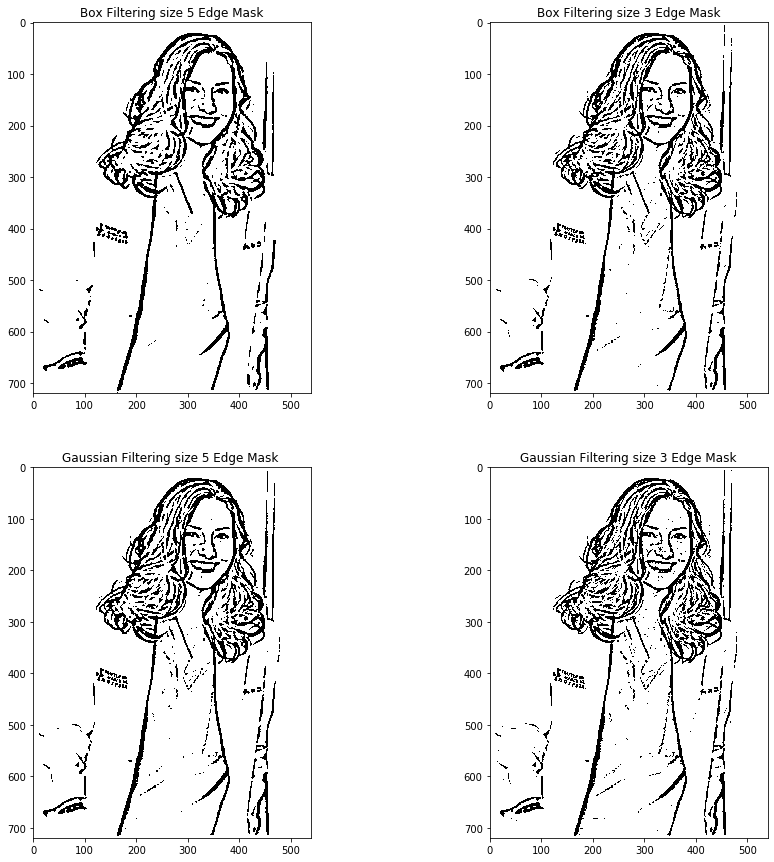

In [20]:
f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0,0].imshow(mk1,cmap="gray")
axarr[0,1].imshow(mk2,cmap="gray")
axarr[1,0].imshow(mk3,cmap="gray")
axarr[1,1].imshow(mk4,cmap="gray")

axarr[0,0].set_title("Box Filtering size 5 Edge Mask")
axarr[0,1].set_title("Box Filtering size 3 Edge Mask")
axarr[1,0].set_title("Gaussian Filtering size 5 Edge Mask ")
axarr[1,1].set_title("Gaussian Filtering size 3 Edge Mask")

## Step 5

In [16]:
def cartoon_effect(img_blur,value,block,constant,bf_img):
    mk = adaptiveThresholding(img_blur,value,block,constant)
#     bg_img = cv.bitwise_and(bf_img,bf_img,mask =mk)
    bg_img = np.zeros_like(bf_img)
    bf_img = bf_img.astype(np.uint8)
    bg_img[:,:,0] = np.bitwise_and(bf_img[:,:,0],mk)
    bg_img[:,:,1] = np.bitwise_and(bf_img[:,:,1],mk)
    bg_img[:,:,2] = np.bitwise_and(bf_img[:,:,2],mk)
    return bg_img.astype(np.uint8)

In [17]:
ce1 = cartoon_effect(box5_blur_lena,255,11,3,r1)
ce2 = cartoon_effect(box3_blur_lena,255,11,3,r1)
ce3 = cartoon_effect(ga5_blur_lena,255,11,3,r1)
ce4 = cartoon_effect(ga3_blur_lena,255,11,3,r1)

Text(0.5, 1.0, 'Gaussian Filtering size 3 Cartoon Image')

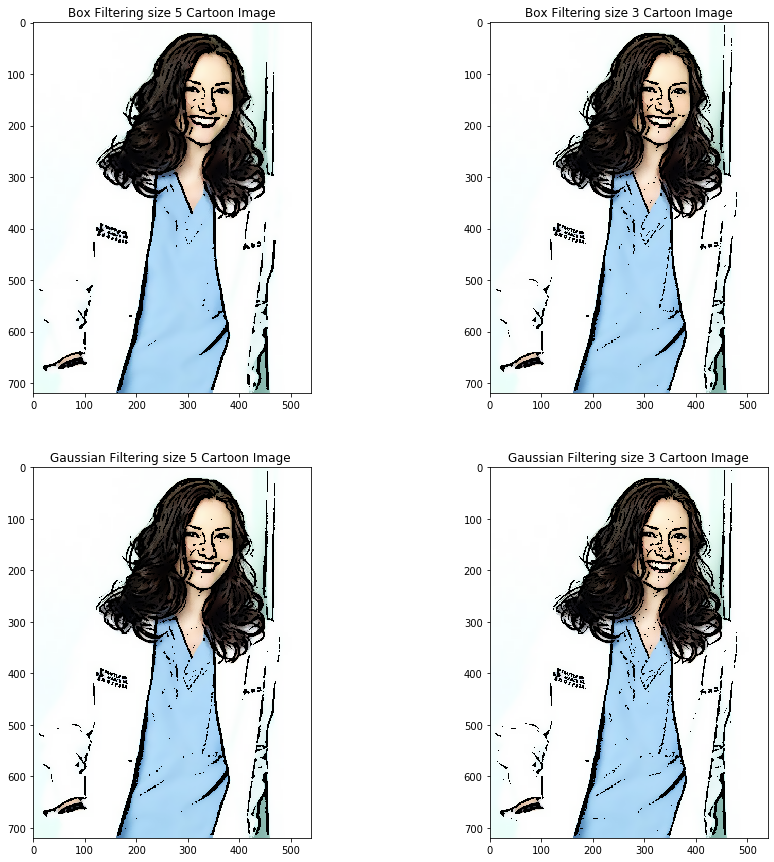

In [18]:
f, axarr = plt.subplots(2,2,figsize=(15,15))
axarr[0,0].imshow(ce1,cmap="gray")
axarr[0,1].imshow(ce2,cmap="gray")
axarr[1,0].imshow(ce3,cmap="gray")
axarr[1,1].imshow(ce4,cmap="gray")

axarr[0,0].set_title("Box Filtering size 5 Cartoon Image")
axarr[0,1].set_title("Box Filtering size 3 Cartoon Image")
axarr[1,0].set_title("Gaussian Filtering size 5 Cartoon Image ")
axarr[1,1].set_title("Gaussian Filtering size 3 Cartoon Image")